# Exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize
import sys
import os

sys.path.append(os.path.abspath("code"))
from utilities import create_receptive_field, create_gaussian_stimuli, generate_data_linear, generate_inhomogeneous_poisson_spikes, generate_data_poisson

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [20]:
def pearson_correlation(K, K_hat):
    K = K.flatten()
    K_hat = K_hat.flatten()
    return (K.T @ K_hat) / (np.linalg.norm(K) * np.linalg.norm(K_hat))

Duration: 5 s, Pearson Correlation: 0.3745355521080015
Duration: 10 s, Pearson Correlation: 0.5366886819309371
Duration: 20 s, Pearson Correlation: 0.6760072919463471
Duration: 40 s, Pearson Correlation: 0.9309529016542644
Duration: 80 s, Pearson Correlation: 0.9750102368571841
Duration: 160 s, Pearson Correlation: 0.9902740673227702
Duration: 320 s, Pearson Correlation: 0.9952620793875212
Duration: 640 s, Pearson Correlation: 0.9978055818054612


Text(0.5, 1.0, 'Effect of Duration on Pearson Correlation')

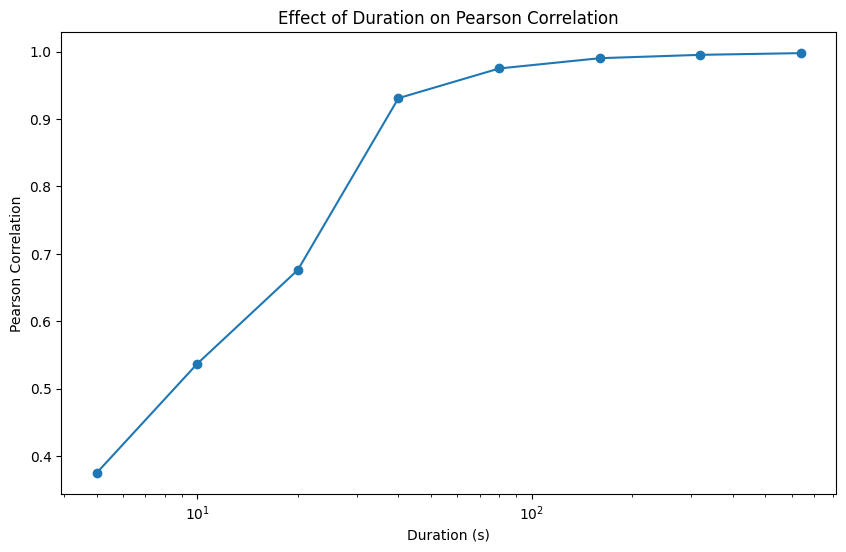

In [30]:
durations = [5, 10, 20, 40, 80, 160, 320, 640]
CC_totals = []
for duration in durations:
    dt = .1
    std_dev = 1
    vf_size = (15,15)
    n_bins = round(duration / float(dt))

    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

    correlations = []
    for i in range(10):
        K = create_receptive_field()

        noise_variance = 1
        offset = 2.

        # flatten the matrices in to 1d array for convenience
        K_flat = K.ravel()
        K_flat = np.hstack((K.flat, offset))

        S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


        # 1. linear stage
        ks = np.dot(K_flat, S_flat.T)

        # 2. nonlinear stage (for a linear model: f -> identity function)
        rate = ks

        # add Gaussian noise centered around the "true" rate for each bin
        rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)

        CC = pearson_correlation(K, K_hat)
        correlations.append(CC)
    
    CC_total = np.mean(correlations)
    print(f"Duration: {duration} s, Pearson Correlation: {CC_total}")
    CC_totals.append(CC_total)

plt.figure(figsize=(10, 6))
plt.plot(durations, CC_totals, marker='o')
plt.xscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Pearson Correlation')
plt.title('Effect of Duration on Pearson Correlation')


A higher correlation means a stronger resemblance between K and K_hat.
As the duration increases, so does the Pearson Correlation and thus resemblance between the recovered K_hat.
So the longer the duration, the better the ability to recover the receptive field.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

Variance: 0, Pearson Correlation: 0.9999999999999998
Variance: 2, Pearson Correlation: 0.9661537742280343
Variance: 4, Pearson Correlation: 0.9363238865388332
Variance: 6, Pearson Correlation: 0.9093473992222982
Variance: 8, Pearson Correlation: 0.8707190701396084
Variance: 10, Pearson Correlation: 0.8618497915691625


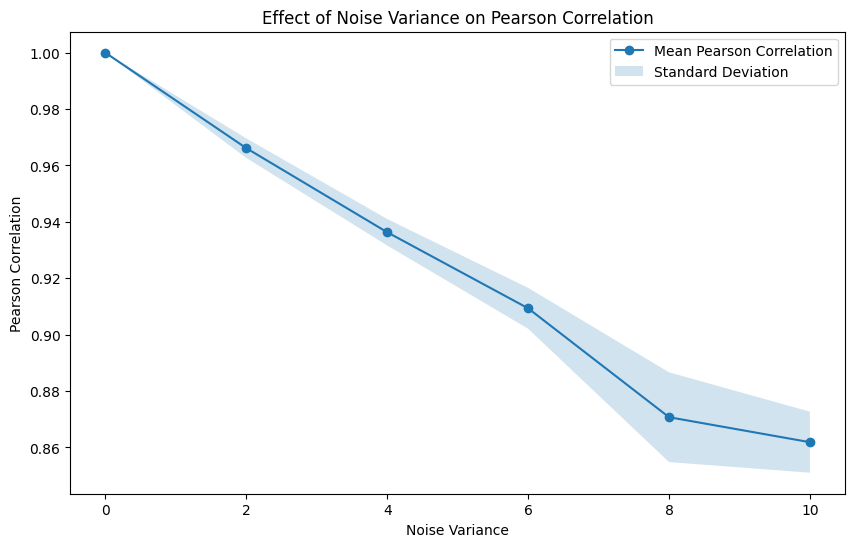

In [34]:
variances = [0, 2, 4, 6, 8, 10]
means = []
stdefs = []
for variance in variances:
    def one_run(variance):
        K, S, ks, rate = generate_data_linear(duration=100, noise_variance=variance)
        K_hat = np.linalg.pinv(S.T @ S) @ (S.T @ rate)
        K_hat = K_hat[:-1].reshape(K.shape)
        return pearson_correlation(K, K_hat)

    CCs = [one_run(variance) for _ in range(10)]
    mean = np.mean(CCs)
    stdef = np.std(CCs)
    means.append(mean)
    stdefs.append(stdef)
    print(f"Variance: {variance}, Pearson Correlation: {mean}")

plt.figure(figsize=(10, 6))
plt.plot(variances, means, marker='o', label='Mean Pearson Correlation')
plt.fill_between(variances, np.array(means) - np.array(stdefs), np.array(means) + np.array(stdefs), alpha=0.2, label='Standard Deviation')
plt.xlabel('Noise Variance')
plt.ylabel('Pearson Correlation')
plt.title('Effect of Noise Variance on Pearson Correlation')
plt.legend()
plt.show()

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




The required terms are all dependent on $k$, so the unrequired terms to not depend on $k$ at all.

$f(\mathbf{k}^T \mathbf{s}) = \lambda_t$

So any term with $\lambda_t$ depends on $k$ and is required (and of course $\lambda_t$ itself is required as well).

$−log(r_t!)$ only depends on $r$ and that's an observation.

So $r_t$, $r_t!$ and $−log(r_t!)$ can all be ignored.

And ofc $\Delta$ is independent of $k$ as we manually set that variable and is not required. 


Furthermore, the log-likelihood is given by:
\begin{equation}
    \log P(R | \lambda) = \sum_t r_t\log \lambda_t + \sum_t r_t\log \Delta - \sum_t \log r_t! - \sum_t \lambda_t \Delta.
\end{equation}

Of these four parameters, only $\sum_t r_t\log \lambda_t$ and $\sum_t \lambda_t \Delta$ are required, $\sum_t r_t\log \Delta$ and $\sum_t \log r_t!$ can be ignored.

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

In [2]:
def fit_model(spike_counts, S_flat, K, dt=0.1):
    # define functions for minimisation
    def cost(k, spike_counts, S, alpha=1):
        #negative loglikelihood function to minimize
        ks = np.dot(k, S.T)
        lamda = np.exp(ks)
        return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
        
    def grad(k, spike_counts, S):
        # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

        ks = np.dot(k, S.T)
        lamda = np.exp(ks)
        return -np.dot(S.T, spike_counts - dt*lamda)

    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x

    print("Pearson correlation = {:.3f}".format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))))

    # show result
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title(r'Receptive field $\mathbf{k}$')
    plt.imshow(K)

    plt.subplot(1,2,2)
    plt.title(r'Estimated receptive field $\mathbf{\hat{k}}$')
    plt.imshow(K_est[:-1].reshape(15, 15)) 

    CC = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))

    return CC

average spike rate: 4.80 spikes per second
Pearson correlation = 0.368
average spike rate: 3.70 spikes per second
Pearson correlation = 0.426
average spike rate: 4.56 spikes per second
Pearson correlation = 0.710
average spike rate: 4.49 spikes per second
Pearson correlation = 0.690
average spike rate: 4.29 spikes per second
Pearson correlation = 0.960


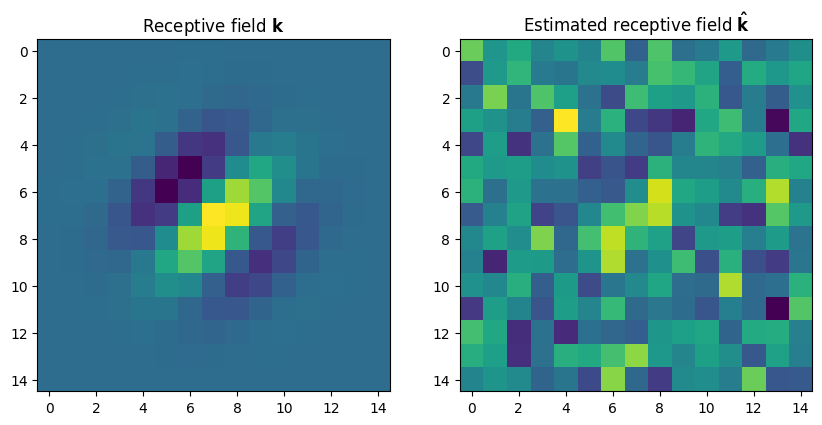

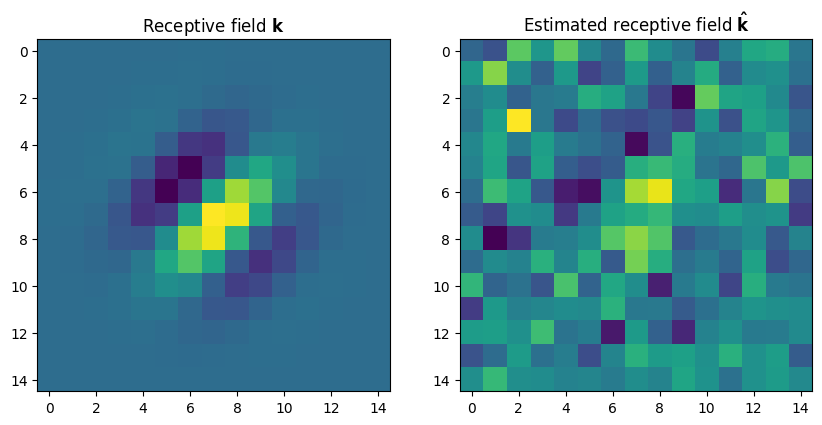

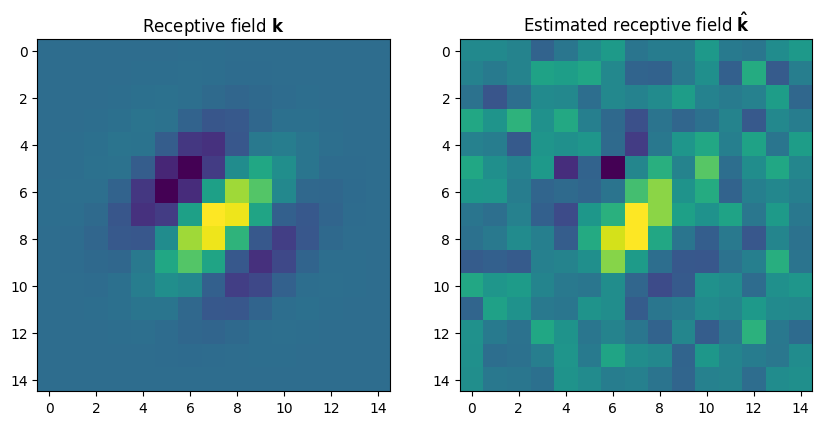

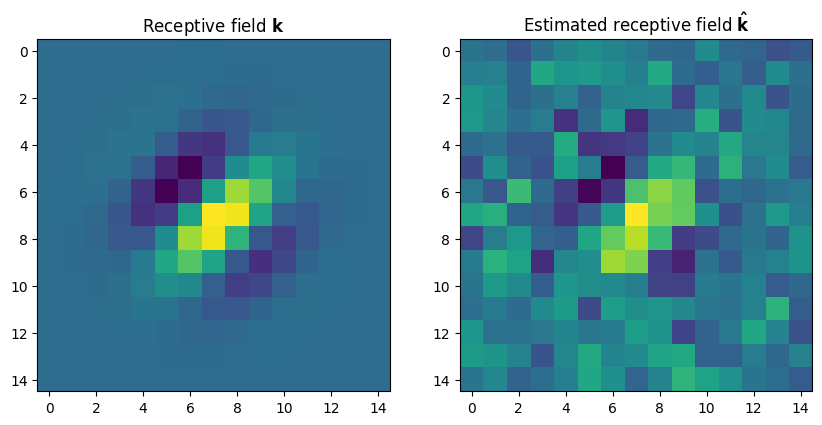

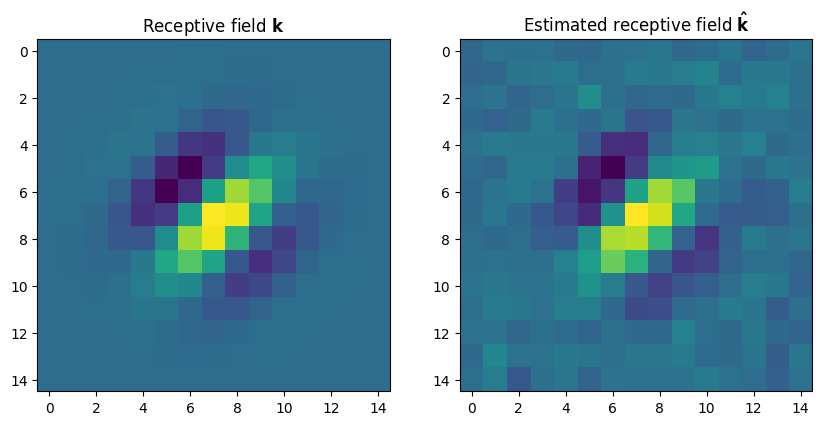

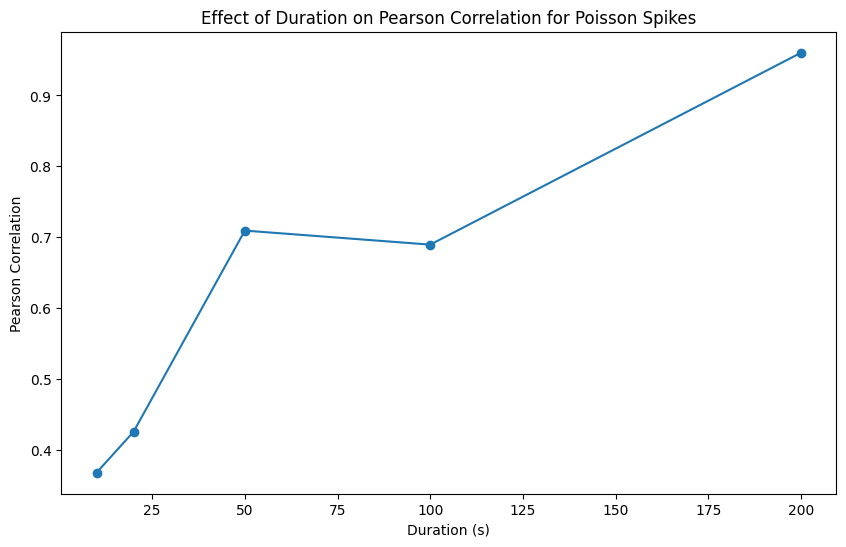

In [12]:
durations = [10, 20, 50, 100, 200]
dt = 0.1
CCs = []
for duration in durations:
    K, S_flat, ks, lamda, spike_times, spike_counts = generate_data_poisson(duration=duration, dt=dt)

    CC = fit_model(spike_counts, S_flat, K, dt=dt)
    CCs.append(CC)

plt.figure(figsize=(10, 6))
plt.plot(durations, CCs, marker='o')
#plt.xscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Pearson Correlation')
plt.title('Effect of Duration on Pearson Correlation for Poisson Spikes')
plt.show()

average spike rate: 0.01 spikes per second
Pearson correlation = 0.145
average spike rate: 0.33 spikes per second
Pearson correlation = 0.569
average spike rate: 0.63 spikes per second
Pearson correlation = 0.601
average spike rate: 1.63 spikes per second
Pearson correlation = 0.710
average spike rate: 4.36 spikes per second
Pearson correlation = 0.746


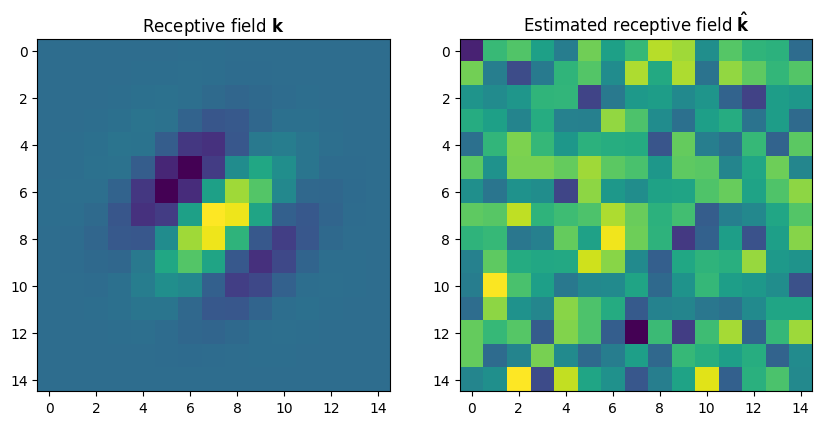

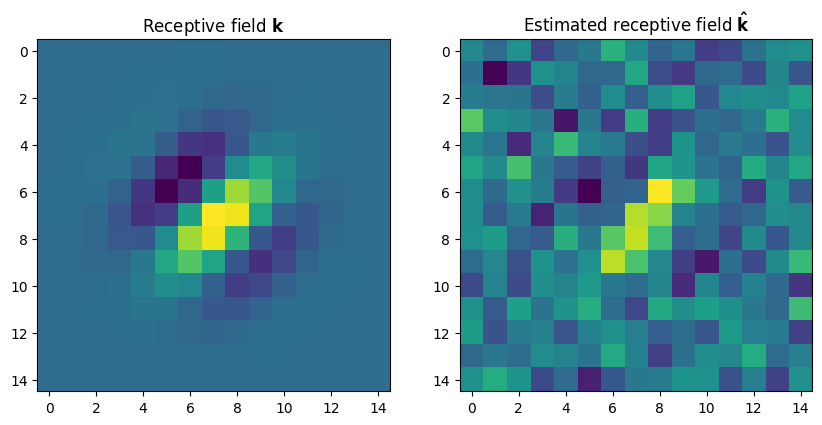

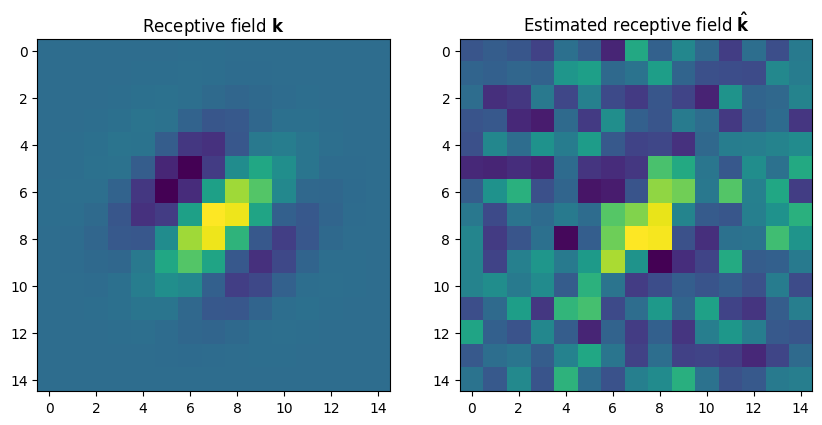

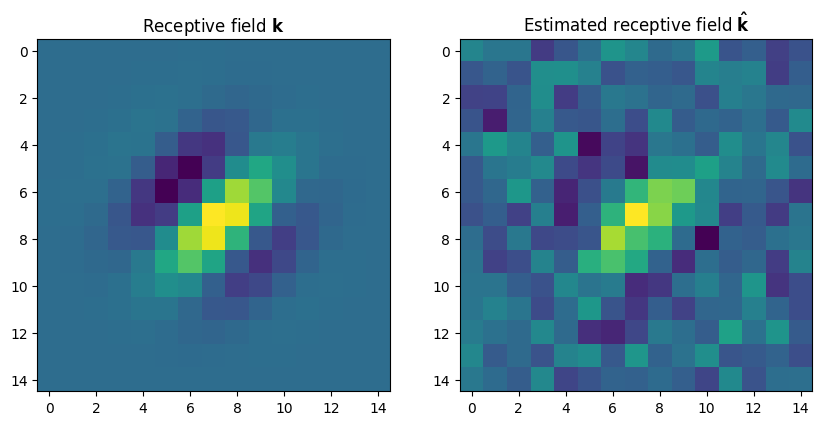

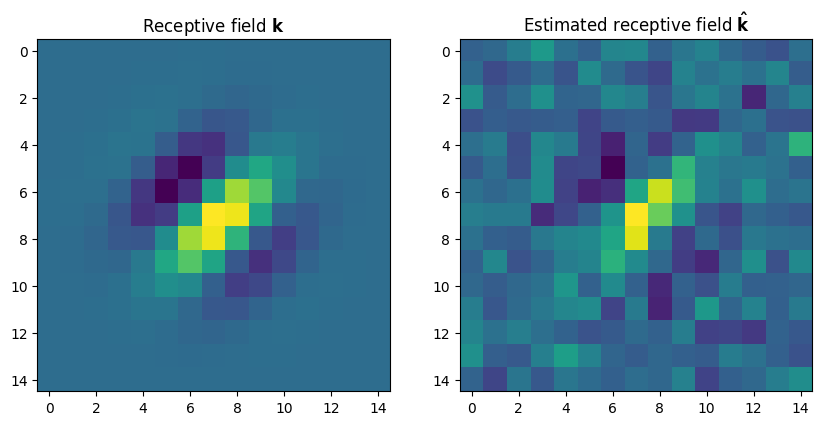

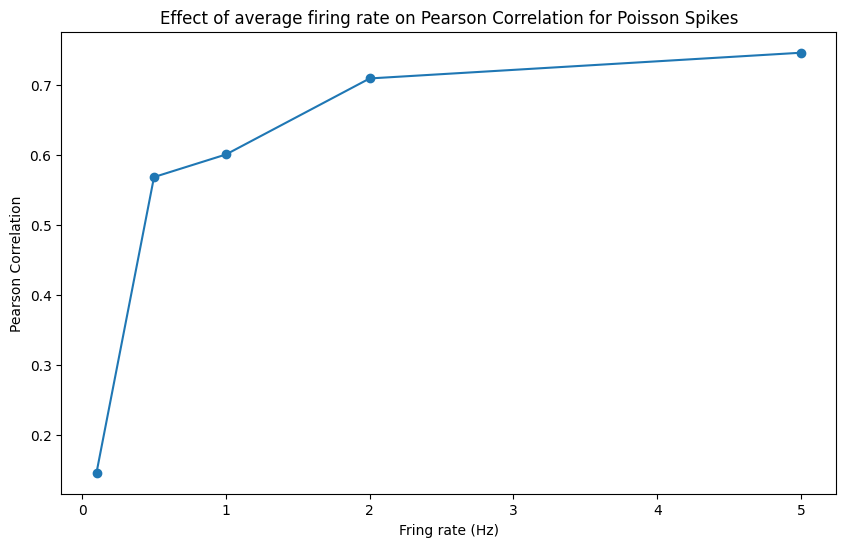

In [14]:
firing_rates = [0.1, 0.5, 1, 2, 5]
dt = 0.1
CCs = []
for firing_rate in firing_rates:
    K, S_flat, ks, lamda, spike_times, spike_counts = generate_data_poisson(duration=100, dt=dt, spike_rate=firing_rate)

    CC = fit_model(spike_counts, S_flat, K, dt=dt)
    CCs.append(CC)

plt.figure(figsize=(10, 6))
plt.plot(firing_rates, CCs, marker='o')
# plt.xscale('log')
plt.xlabel('Fring rate (Hz)')
plt.ylabel('Pearson Correlation')
plt.title('Effect of average firing rate on Pearson Correlation for Poisson Spikes')
plt.show()

A: the duration seems to almost linearly increase (with some outliers) the pearson correlation between the true and estimated receptive fields.

B: increased firing rate also result in more accurate receptive field simulations. But after 2 hz, increasing the firing rate seems to have no effect (I checked for multiple simulations, it even goes back down again sometimes). 
The relationship between the firing rate and accuracy seems to follow some sort of inversed exponential or perhaps logarithmic shape, but I can't say for sure. I was wondering whether this is caused by the log likelihood function we fitted the model for.